In [10]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.plot import plot, add_changepoints_to_plot
import numpy as np

plt.style.use('seaborn')

pd.set_option('display.max_rows', 250)
%matplotlib inline

In [11]:
df = pd.read_csv('kpis_with_flags.csv',parse_dates = ['observation_date'])

print('Dataset Shape:', df.shape)
print('Max Obs. Date:',df['observation_date'].min())
print('Max Obs. Date:',df['observation_date'].max())
df.head()

Dataset Shape: (1826, 7)
Max Obs. Date: 2017-01-01 00:00:00
Max Obs. Date: 2021-12-31 00:00:00


,observation_date,sales_num,sales_value_gbp,fl_last_working_day,fl_first_working_day,fl_last_friday,fl_new_year
0,2017-01-01,779.0,453330.60,0,0,0,1
1,2017-01-02,1158.0,869178.32,0,1,0,0
2,2017-01-03,1406.0,1169019.45,0,0,0,0
3,2017-01-04,1484.0,1216797.41,0,0,0,0
4,2017-01-05,1516.0,1265103.60,0,0,0,0


Text(0.5, 1.0, 'Sales Value (£M) By Day')

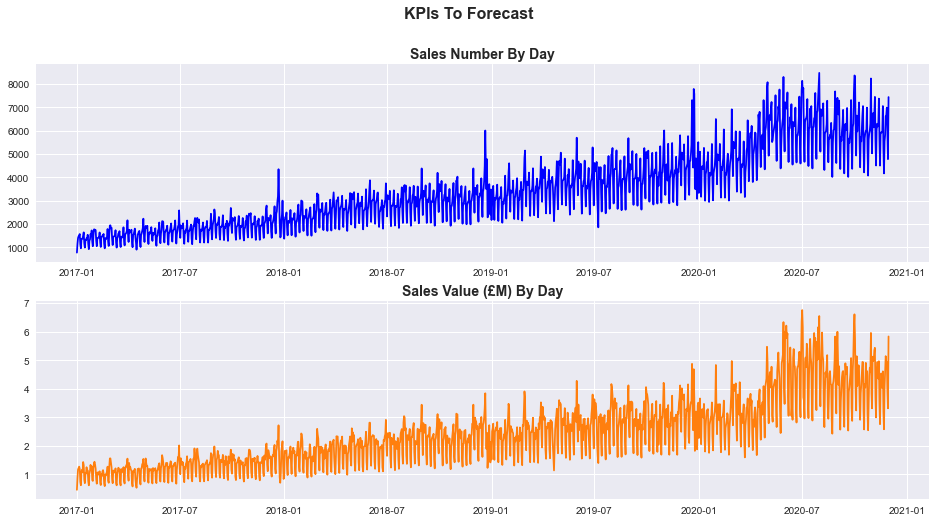

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (16, 8))
fig.suptitle('KPIs To Forecast', fontsize=16, fontweight="bold")

ax1.plot(df['observation_date'], df['sales_num'], color = 'blue')
ax2.plot(df['observation_date'], (df['sales_value_gbp']/1000000), 'tab:orange')

ax1.set_title('Sales Number By Day', fontsize=14,fontweight='heavy')
ax2.set_title('Sales Value (£M) By Day', fontsize=14, fontweight='heavy' )

In [13]:
cutoff_date = pd.to_datetime('2020-10-31') 
test_end_date = pd.to_datetime('2020-11-30')

forecast_start_date = pd.to_datetime('2020-11-01')
forecast_end_date = pd.to_datetime('2022-01-01')
days_to_forecast = pd.Timedelta(forecast_end_date - forecast_start_date).days



kpis = ['sales_num']
#kpis = ['sales_num', 'sales_value_gbp']

for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['observation_date'] <= cutoff_date ), ['observation_date', kpi]]

    df_train = df_train.rename(columns={'observation_date': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                    growth = 'linear', 
                    seasonality_mode = 'multiplicative',
                    daily_seasonality = False,
                    weekly_seasonality=True,
                    yearly_seasonality=True
                    )
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods= days_to_forecast )
    forecast = model.predict(future_data)[['ds','yhat_lower', 'yhat','yhat_upper', 'trend']]
    df.loc[(df['observation_date'] > cutoff_date ), kpi ] = forecast['yhat'].astype(int)

df.tail(10)

Forecasting KPI:  sales_num


23:23:47 - cmdstanpy - INFO - Chain [1] start processing
23:23:47 - cmdstanpy - INFO - Chain [1] done processing


,observation_date,sales_num,sales_value_gbp,fl_last_working_day,fl_first_working_day,fl_last_friday,fl_new_year
1816,2021-12-22,10128.0,NaN,0,0,0,0
1817,2021-12-23,10319.0,NaN,0,0,0,0
1818,2021-12-24,11640.0,NaN,0,0,0,0
1819,2021-12-25,8603.0,NaN,0,0,0,0
1820,2021-12-26,6840.0,NaN,0,0,0,0
1821,2021-12-27,9206.0,NaN,0,0,0,0
1822,2021-12-28,9226.0,NaN,0,0,0,0
1823,2021-12-29,9384.0,NaN,0,0,0,0
1824,2021-12-30,9511.0,NaN,0,0,0,0
1825,2021-12-31,10787.0,NaN,1,0,1,0


Text(105.25, 0.5, 'Sales Number - Daily')

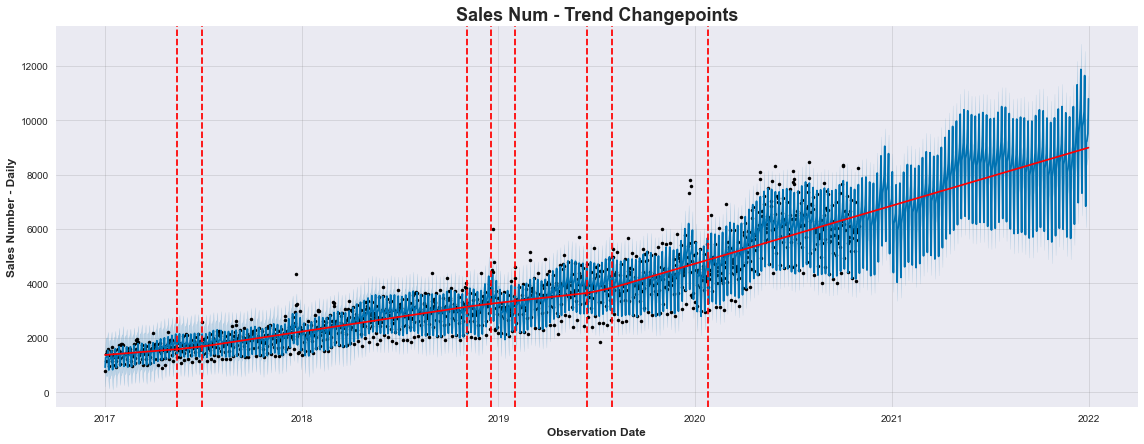

In [14]:
fig = plot(model, forecast, figsize=(16, 6));
ax = fig.gca()
add_changepoints_to_plot(ax, model, forecast)


ax.set_title("Sales Num - Trend Changepoints", size=18, fontweight='heavy')
ax.set_xlabel('Observation Date', size = '12' , fontweight='heavy')
ax.set_ylabel('Sales Number - Daily', fontweight='heavy', size = '12')

,observation_date,sales_num,yhat_lower,yhat,yhat_upper,trend
1821,2021-12-27,9206.0,8324.555646,9206.217176,10064.553901,8967.749340
1822,2021-12-28,9226.0,8398.594518,9226.233230,10054.097311,8973.593670
1823,2021-12-29,9384.0,8522.930281,9384.784964,10181.126493,8979.437999
1824,2021-12-30,9511.0,8639.650209,9511.519027,10345.031281,8985.282329
1825,2021-12-31,10787.0,9856.527545,10787.610772,11638.588975,8991.126658


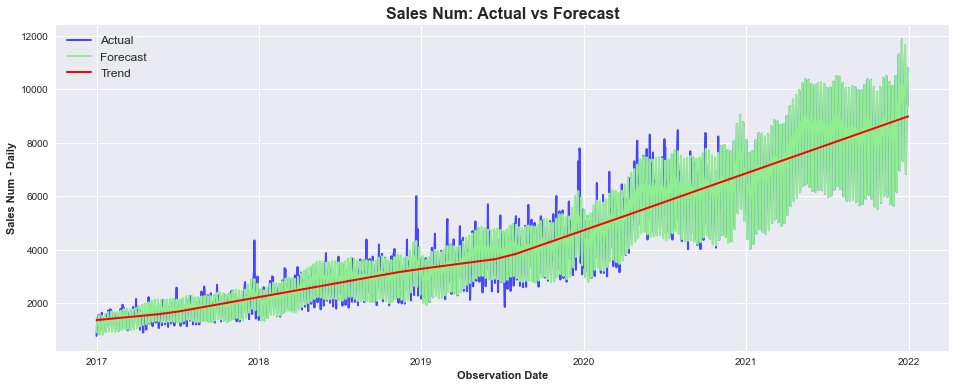

In [15]:
# Join Original Dataset With Forecast
combined_df = df.join(forecast, how = 'outer')

plt.figure(figsize=(16,6))
plt.plot(combined_df['observation_date'], combined_df['sales_num'], 
         linewidth=2, color = 'blue' ,alpha = 0.7, label = 'Actual')
plt.plot(combined_df['observation_date'], combined_df['yhat'], 
         linewidth=2, color = 'lightgreen', label = 'Forecast')
plt.plot(combined_df['observation_date'], combined_df['trend'], 
         linewidth=2, color = 'red', label = 'Trend')

plt.title('Sales Num: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Observation Date', fontweight='heavy')
plt.ylabel('Sales Num - Daily', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

#plt.xlim(pd.to_datetime('2019-10-01'), pd.to_datetime('2019-12-31'))
combined_df[['observation_date', 'sales_num', 'yhat_lower' , 'yhat', 'yhat_upper' ,'trend']].tail()

Text(0, 0.5, 'Sales Num - Daily')

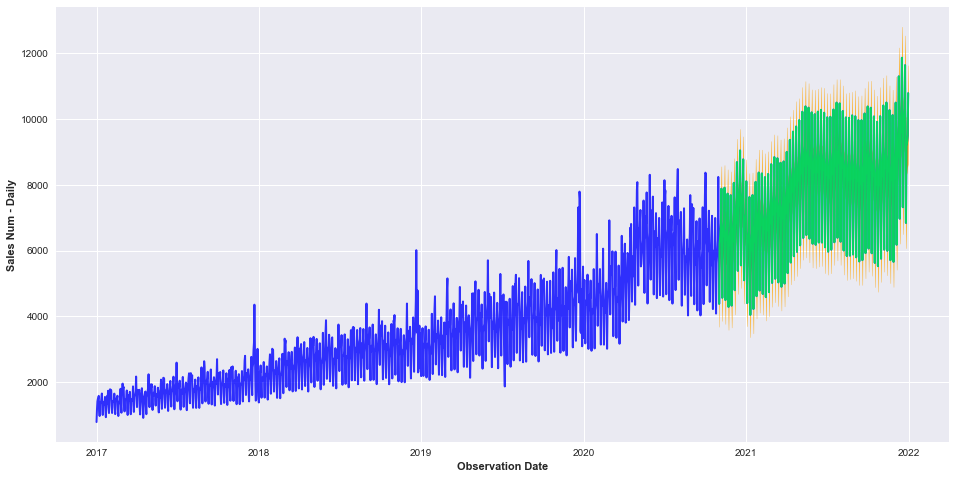

In [16]:
forecast_adj = forecast.loc[forecast['ds'] >=forecast_start_date, ['yhat_lower','yhat','yhat_upper']]
combined_df_adj = df.join(forecast_adj, how = 'outer')

plt.figure(figsize=(16,8))
plt.plot(combined_df_adj['observation_date'], combined_df_adj['sales_num'], 
         linewidth=2, color = 'blue' ,alpha = 0.8, label = 'Actual')
plt.plot(combined_df_adj['observation_date'], combined_df_adj['yhat'], 
         linewidth=2, color = '#00ff41', alpha = 0.8 , label = 'Forecast (1st Nov 2020 to 31st Dec 2021)')
plt.fill_between(combined_df_adj['observation_date'], combined_df_adj['yhat_upper'], combined_df_adj['yhat_lower'], 
                 color='orange', label = 'Uncertainty Interval')

#plt.title('Sales Num: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Observation Date', fontweight='heavy')
plt.ylabel('Sales Num - Daily', fontweight='heavy')
#plt.legend(loc="upper left", fontsize = 'large')

#plt.xlim(pd.to_datetime('2020-11-01'), pd.to_datetime('2020-12-31'))

In [17]:
combined_df_test = combined_df.loc[(combined_df['observation_date'] > cutoff_date)
                                    & (combined_df['observation_date'] <= test_end_date )]


mape =(np.mean(np.abs(combined_df_test['sales_num']-combined_df_test['yhat'])/
               np.abs(combined_df_test['sales_num'])))*100
print('MAPE:',  mape)

MAPE: 0.008501034936729514


In [20]:
df = pd.read_csv('kpis_with_flags.csv',parse_dates = ['observation_date'])

print('Max Obs. Date:',df['observation_date'].min())
print('Max Obs. Date:',df['observation_date'].max())
df.head()

Max Obs. Date: 2017-01-01 00:00:00
Max Obs. Date: 2021-12-31 00:00:00


,observation_date,sales_num,sales_value_gbp,fl_last_working_day,fl_first_working_day,fl_last_friday,fl_new_year
0,2017-01-01,779.0,453330.60,0,0,0,1
1,2017-01-02,1158.0,869178.32,0,1,0,0
2,2017-01-03,1406.0,1169019.45,0,0,0,0
3,2017-01-04,1484.0,1216797.41,0,0,0,0
4,2017-01-05,1516.0,1265103.60,0,0,0,0


In [21]:
### 1. GENERATE LIST OF DATES EXTRACTED FROM FLAGS ###
fl_last_working_day = df.loc[df['fl_last_working_day'] == 1]['observation_date'].to_list()

fl_first_working_day = df.loc[df['fl_first_working_day'] == 1]['observation_date'].to_list()

fl_last_friday = df.loc[df['fl_last_friday'] == 1]['observation_date'].to_list()

fl_new_year = df.loc[df['fl_new_year'] == 1]['observation_date'].to_list()


### 2. CREATE A DATAFRAME FOR EACH RECURRING EVENT ###
First_Working_Day = pd.DataFrame({'holiday': 'First_Working_Day',
                                  'ds':  pd.to_datetime(fl_first_working_day),
                                  'lower_window': 0,
                                  'upper_window': 0 })

Last_Working_Day = pd.DataFrame({'holiday': 'Last_Working_Day',
                                 'ds':  pd.to_datetime(fl_last_working_day),
                                 'lower_window': 0,
                                 'upper_window': 0 })

Last_Friday = pd.DataFrame({'holiday': 'Last_Friday',
                            'ds':  pd.to_datetime(fl_last_friday),
                            'lower_window': 0,
                            'upper_window': 0 })

New_Year = pd.DataFrame({'holiday': 'New_Year',
                         'ds':  pd.to_datetime(fl_new_year),
                         'lower_window': 0,
                         'upper_window': 0 })

# manually imputed dates covering oberved + forecast period
Christmas = pd.DataFrame({'holiday': 'Christmas',
                         'ds': pd.to_datetime(['2017-12-25','2018-12-25', 
                                               '2019-12-25', '2020-12-25', 
                                               '2021-12-25']),
                         'lower_window': -3,
                         'upper_window': 3 })
# manually imputed dates covering oberved + forecast period
Easter = pd.DataFrame({'holiday': 'Easter',
                         'ds': pd.to_datetime(['2017-04-16', '2018-04-01', 
                                              '2019-04-21', '2020-04-12',
                                              '2021-04-04']),
                         'lower_window': -4,
                         'upper_window': 2 })

# 3. CONCATENATE SINGLE DATAFRAMES TO FORM HOLIDAYS DATAFRAME

holidays= pd.concat([First_Working_Day, Last_Working_Day, Last_Friday, 
                     New_Year, Christmas, Easter])

#holidays.head(5)
#holidays.tail(5)

cutoff_date = pd.to_datetime('2020-10-31') 
test_end_date = pd.to_datetime('2020-11-30')

forecast_start_date = pd.to_datetime('2020-11-01')
forecast_end_date = pd.to_datetime('2022-01-01')
days_to_forecast = pd.Timedelta(forecast_end_date - forecast_start_date).days

In [22]:
kpis = ['sales_num']

for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['observation_date'] <= cutoff_date ), ['observation_date', kpi]]

    df_train = df_train.rename(columns={'observation_date': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                    growth = 'linear', 
                    seasonality_mode = 'multiplicative',
                    daily_seasonality = False,
                    weekly_seasonality=True,
                    yearly_seasonality=True,
                    holidays=holidays,
                    changepoint_prior_scale=0.1,
                    #changepoint_range=0.85,
                    )
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods= days_to_forecast )
    
    forecast = model.predict(future_data)
#     df.loc[(df['observation_date'] > cutoff_date ), kpi ] = forecast['yhat'].astype(int)

df.tail(10)

Forecasting KPI:  sales_num


23:24:34 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing


,observation_date,sales_num,sales_value_gbp,fl_last_working_day,fl_first_working_day,fl_last_friday,fl_new_year
1816,2021-12-22,NaN,NaN,0,0,0,0
1817,2021-12-23,NaN,NaN,0,0,0,0
1818,2021-12-24,NaN,NaN,0,0,0,0
1819,2021-12-25,NaN,NaN,0,0,0,0
1820,2021-12-26,NaN,NaN,0,0,0,0
1821,2021-12-27,NaN,NaN,0,0,0,0
1822,2021-12-28,NaN,NaN,0,0,0,0
1823,2021-12-29,NaN,NaN,0,0,0,0
1824,2021-12-30,NaN,NaN,0,0,0,0
1825,2021-12-31,NaN,NaN,1,0,1,0


In [23]:
combined_df = df.join(forecast, how = 'outer')
combined_df_test = combined_df.loc[(combined_df['observation_date'] > cutoff_date)
                                    & (combined_df['observation_date'] <= test_end_date )]

mape =(np.mean(np.abs(combined_df_test['sales_num']-combined_df_test['yhat'])/
               np.abs(combined_df_test['sales_num'])))*100
mape

4.783381477782662

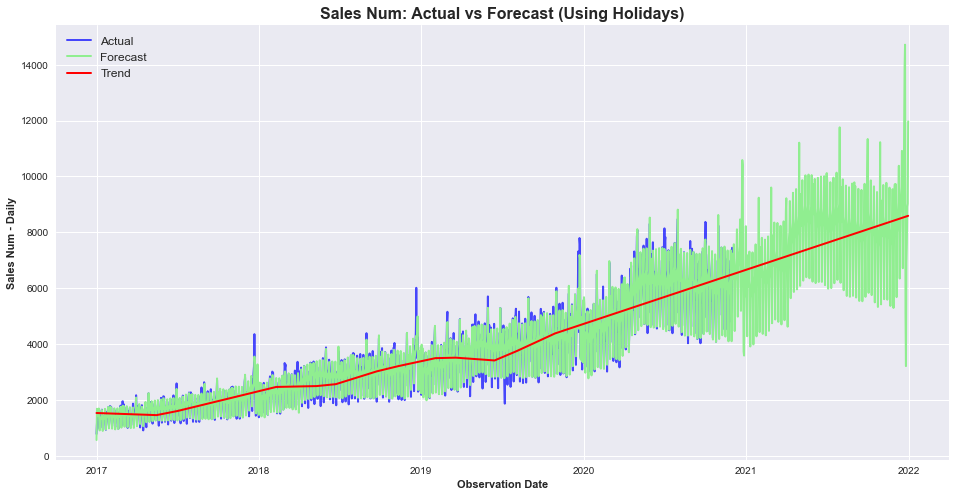

In [24]:
plt.figure(figsize=(16,8))
plt.plot(combined_df['observation_date'], combined_df['sales_num'], 
         linewidth=2, color = 'blue' ,alpha = 0.7, label = 'Actual')
plt.plot(combined_df['observation_date'], combined_df['yhat'], 
         linewidth=2, color = 'lightgreen', label = 'Forecast')
plt.plot(combined_df['observation_date'], combined_df['trend'], 
         linewidth=2, color = 'red', label = 'Trend')

plt.title('Sales Num: Actual vs Forecast (Using Holidays)', fontsize=16, fontweight='heavy' )
plt.xlabel('Observation Date', fontweight='heavy')
plt.ylabel('Sales Num - Daily', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

In [25]:
kpis = ['sales_num']

for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['observation_date'] <= cutoff_date ), ['observation_date', kpi]]

    df_train = df_train.rename(columns={'observation_date': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                    growth = 'linear',
                    seasonality_mode = 'multiplicative',
                    #seasonality_prior_scale = 15, #alternatively set global parameter
                    daily_seasonality=False,
                    weekly_seasonality=False, 
                    yearly_seasonality=False,
                    holidays=holidays,
                    holidays_prior_scale = 10,
                    ).add_seasonality(
                   name = 'weekly',
                    period = 7,
                    fourier_order = 5,
                    prior_scale = 15
                    ).add_seasonality(
                    name = 'monthly',
                    period = 30.5,
                    fourier_order = 14,
                    prior_scale = 15
                    ).add_seasonality(
                    name = 'yearly',
                    period = 365.25,
                    fourier_order = 10,
                    prior_scale = 15
                    )
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods= days_to_forecast )
    forecast = model.predict(future_data)

combined_df = df.join(forecast, how = 'outer')
combined_df_test = combined_df.loc[(combined_df['observation_date'] > cutoff_date)
                                    & (combined_df['observation_date'] <= test_end_date )]

mape =(np.mean(np.abs(combined_df_test['sales_num']-combined_df_test['yhat'])/
               np.abs(combined_df_test['sales_num'])))*100
mape

Forecasting KPI:  sales_num


23:25:01 - cmdstanpy - INFO - Chain [1] start processing
23:25:01 - cmdstanpy - INFO - Chain [1] done processing


3.621044758894307